Dataset shape: (155, 20)
Class distribution (1=DIE, 0=LIVE):
 Class
0    123
1     32
Name: count, dtype: int64

✅ Preprocessing complete. Train: (124, 19) Test: (31, 19)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



===== TOP 10 CLUSTERING COMBINATIONS (train set) =====


,DR,Clustering,Params,Silhouette,DBI,CHI,NumLabels
0,tsne,dbscan,eps=0.9,0.914518,0.100873,811.051086,3
1,pca,dbscan,eps=0.3,0.734466,0.324794,195.722202,5
2,umap,dbscan,eps=0.3,0.609601,0.483007,770.757874,8
3,tsne,hdbscan,min_cluster_size=10,0.577482,0.481863,95.973106,3
4,pca,hdbscan,min_cluster_size=8,0.571887,0.507466,104.913145,3
5,pca,dbscan,eps=0.7,0.570643,0.514709,108.016434,3
6,tsne,dbscan,eps=1.1,0.557018,0.539368,244.706955,6
7,pca,hdbscan,min_cluster_size=10,0.555680,0.502449,71.302490,3
8,pca,hdbscan,min_cluster_size=5,0.538995,0.541350,84.320762,3
9,tsne,hdbscan,min_cluster_size=5,0.537175,0.539259,160.855072,6



✅ BEST CONFIG (quality/visualization): {'DR': 'tsne', 'Clustering': 'dbscan', 'Params': 'eps=0.9', 'Silhouette': np.float64(0.9145177602767944), 'DBI': np.float64(0.10087320584958656), 'CHI': np.float64(811.0510864257812), 'NumLabels': np.int64(3)}


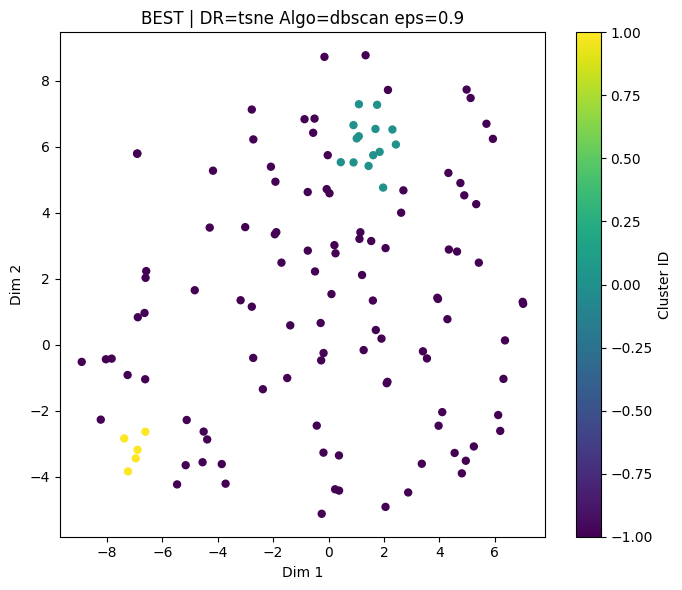


===== CLUSTER SUMMARY (Interpretation) =====


,cluster_id,n,die_rate,mean_age,mean_bilirubin,mean_albumin,mean_protime,mean_sgot,risk_score
0,0,14,0.0,33.071429,0.878571,4.200000,63.642857,74.428571,1.333333
1,-1,105,0.2,41.857143,1.470476,3.849524,62.200000,87.247619,1.666667
2,1,5,1.0,46.000000,2.300000,2.520000,40.200000,59.600000,2.000000



===== 5-FOLD CV RESULTS (Leakage-free) =====


,Model,Setting,CV_Accuracy,CV_F1
0,LogReg,NoCluster,0.838667,0.606667
1,LogReg,WithCluster,0.846667,0.637778
2,RandomForest,NoCluster,0.838000,0.534444
3,RandomForest,WithCluster,0.846000,0.518254
4,XGBoost,NoCluster,0.821000,0.489744
5,XGBoost,WithCluster,0.821333,0.513077



===== FINAL TEST EVALUATION (XGBoost) =====


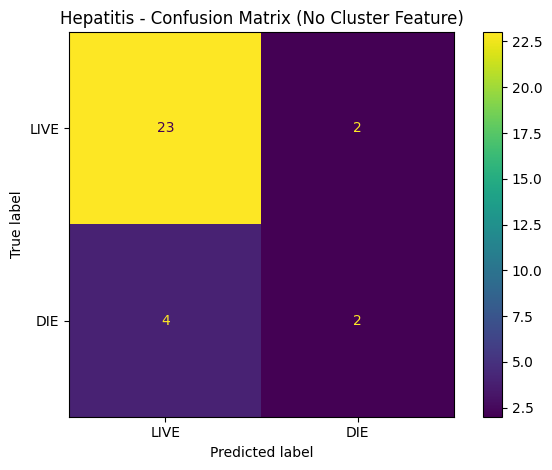

No Cluster Test Accuracy: 0.8064516129032258
              precision    recall  f1-score   support

        LIVE       0.85      0.92      0.88        25
         DIE       0.50      0.33      0.40         6

    accuracy                           0.81        31
   macro avg       0.68      0.63      0.64        31
weighted avg       0.78      0.81      0.79        31



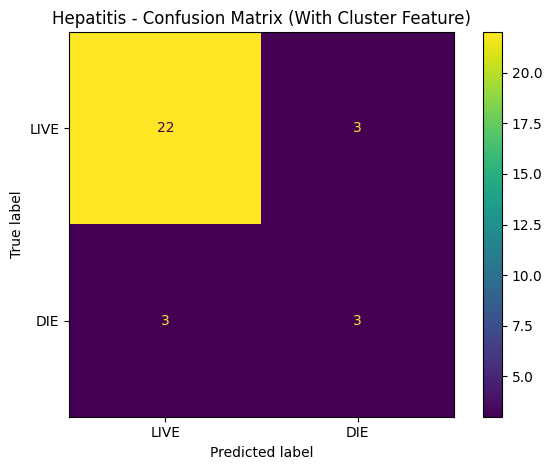

With Cluster Test Accuracy: 0.8064516129032258
              precision    recall  f1-score   support

        LIVE       0.88      0.88      0.88        25
         DIE       0.50      0.50      0.50         6

    accuracy                           0.81        31
   macro avg       0.69      0.69      0.69        31
weighted avg       0.81      0.81      0.81        31


✅ Summary:
Best DR/Cluster (quality/visualization): tsne dbscan eps=0.9
Cluster feature used for prediction: KMeans k = 3
No Cluster  (Test Acc): 0.8064516129032258
With Cluster(Test Acc): 0.8064516129032258


In [ ]:
# ===================== ONE-CELL: Hepatitis (DR + Clustering incl. HDBSCAN + With/Without Cluster Classification) =====================
# Colab: upload hepatitis.data then set path="/content/hepatitis.data"

import sys, subprocess
def _pip(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pkg])

# --- deps ---
try:
    import umap.umap_ as umap
except Exception:
    _pip("umap-learn")
    import umap.umap_ as umap

try:
    import hdbscan
except Exception:
    _pip("hdbscan")
    import hdbscan

try:
    import xgboost
except Exception:
    _pip("xgboost")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display  # ✅ FIX: needed for display()

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# ------------------- 1) Load dataset -------------------
path = "/content/hepatitis.data"  # change if needed

columns = [
    "Class","Age","Sex","Steroid","Antivirals","Fatigue","Malaise",
    "Anorexia","Liver_Big","Liver_Firm","Spleen_Palpable","Spiders",
    "Ascites","Varices","Bilirubin","Alk_Phosphate","SGOT",
    "Albumin","Protime","Histology"
]
df = pd.read_csv(path, names=columns)
df.replace("?", np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors="coerce")

# UCI Hepatitis: Class 1 = DIE, 2 = LIVE -> map to 1=DIE, 0=LIVE
df["Class"] = df["Class"].map({1: 1, 2: 0})

X = df.drop(columns=["Class"]).copy()
y = df["Class"].astype(int).copy()

print("Dataset shape:", df.shape)
print("Class distribution (1=DIE, 0=LIVE):\n", y.value_counts())

# ------------------- 2) Split -------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------- 3) Preprocess -------------------
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
X_train_scaled = preprocess.fit_transform(X_train_raw)
X_test_scaled  = preprocess.transform(X_test_raw)

feature_names = X.columns.tolist()
print("\n✅ Preprocessing complete. Train:", X_train_scaled.shape, "Test:", X_test_scaled.shape)

# ------------------- 4) DR helpers -------------------
def get_dr_embeddings(X_scaled, method="pca", random_state=42):
    if method == "none":
        return X_scaled
    if method == "pca":
        return PCA(n_components=2, random_state=random_state).fit_transform(X_scaled)
    if method == "tsne":
        # ✅ FIX: perplexity must be < n_samples
        n = X_scaled.shape[0]
        perp = min(30, max(5, (n - 1) // 3))
        return TSNE(
            n_components=2, perplexity=perp, learning_rate="auto",
            init="pca", random_state=random_state
        ).fit_transform(X_scaled)
    if method == "umap":
        return umap.UMAP(n_components=2, random_state=random_state).fit_transform(X_scaled)
    raise ValueError("Unknown DR method")

def plot_2d(X_2d, labels, title):
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=25)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(label="Cluster ID")
    plt.tight_layout()
    plt.show()

# ------------------- 5) Clustering + scoring helpers -------------------
def run_clustering(X_emb, algo, k=3, eps=0.8, min_samples=5, min_cluster_size=10, random_state=42):
    if algo == "kmeans":
        return KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit_predict(X_emb)
    if algo == "hierarchical":
        return AgglomerativeClustering(n_clusters=k).fit_predict(X_emb)
    if algo == "dbscan":
        return DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_emb)
    if algo == "hdbscan":
        return hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(X_emb)
    raise ValueError("Unknown clustering algo")

def safe_cluster_scores(X_emb, labels):
    labels = np.asarray(labels)
    uniq = set(labels.tolist())
    if len(uniq) <= 1:
        return None

    # handle noise (-1)
    if -1 in uniq:
        mask = labels != -1
        if mask.sum() < 10:
            return None
        X2 = X_emb[mask]
        y2 = labels[mask]
        if len(set(y2.tolist())) <= 1:
            return None
        sil = silhouette_score(X2, y2)
        dbi = davies_bouldin_score(X2, y2)
        chi = calinski_harabasz_score(X2, y2)
        return sil, dbi, chi

    sil = silhouette_score(X_emb, labels)
    dbi = davies_bouldin_score(X_emb, labels)
    chi = calinski_harabasz_score(X_emb, labels)
    return sil, dbi, chi

# ------------------- 6) DR × Clustering benchmarks (Evaluation & Interpretation) -------------------
dr_methods = ["none", "pca", "tsne", "umap"]

rows = []
for dr in dr_methods:
    X_emb = get_dr_embeddings(X_train_scaled, method=dr, random_state=42)

    # KMeans / Hierarchical
    for algo in ["kmeans", "hierarchical"]:
        for k in [2,3,4,5]:
            labels = run_clustering(X_emb, algo=algo, k=k, random_state=42)
            scores = safe_cluster_scores(X_emb, labels)
            if scores is None:
                continue
            sil, dbi, chi = scores
            rows.append([dr, algo, f"k={k}", sil, dbi, chi, len(set(labels))])

    # DBSCAN
    for eps in [0.3,0.5,0.7,0.9,1.1]:
        labels = run_clustering(X_emb, algo="dbscan", eps=eps, min_samples=5, random_state=42)
        scores = safe_cluster_scores(X_emb, labels)
        if scores is None:
            continue
        sil, dbi, chi = scores
        rows.append([dr, "dbscan", f"eps={eps}", sil, dbi, chi, len(set(labels))])

    # HDBSCAN
    for mcs in [5,8,10,12,15]:
        labels = run_clustering(X_emb, algo="hdbscan", min_cluster_size=mcs, random_state=42)
        scores = safe_cluster_scores(X_emb, labels)
        if scores is None:
            continue
        sil, dbi, chi = scores
        rows.append([dr, "hdbscan", f"min_cluster_size={mcs}", sil, dbi, chi, len(set(labels))])

bench = pd.DataFrame(rows, columns=["DR","Clustering","Params","Silhouette","DBI","CHI","NumLabels"])

# ✅ FIX: if everything fails, fallback
if bench.empty:
    print("\n⚠️ No valid clustering scores produced (often due to noise/1-cluster results).")
    print("Falling back to: DR='pca', Algo='kmeans', k=3")
    best_dr, best_algo, best_params = "pca", "kmeans", "k=3"
else:
    bench = bench.sort_values(by=["Silhouette","DBI","CHI"], ascending=[False, True, False]).reset_index(drop=True)
    print("\n===== TOP 10 CLUSTERING COMBINATIONS (train set) =====")
    display(bench.head(10))
    best = bench.iloc[0]
    best_dr = best["DR"]
    best_algo = best["Clustering"]
    best_params = str(best["Params"])
    print("\n✅ BEST CONFIG (quality/visualization):", dict(best))

# parse best params
k_best = 3
eps_best = 0.8
mcs_best = 10
if best_params.startswith("k="):
    k_best = int(best_params.split("=")[1])
elif best_params.startswith("eps="):
    eps_best = float(best_params.split("=")[1])
elif best_params.startswith("min_cluster_size="):
    mcs_best = int(best_params.split("=")[1])

X_best_2d = get_dr_embeddings(X_train_scaled, method=best_dr, random_state=42)
labels_best = run_clustering(X_best_2d, algo=best_algo, k=k_best, eps=eps_best, min_cluster_size=mcs_best, random_state=42)
if best_dr != "none":
    plot_2d(X_best_2d, labels_best, f"BEST | DR={best_dr} Algo={best_algo} {best_params}")

# ------------------- 7) Cluster interpretation summary -------------------
train_imp = preprocess.named_steps["imputer"].transform(X_train_raw)  # numeric imputed (no scaling)
train_df = pd.DataFrame(train_imp, columns=feature_names)
train_df["cluster_id"] = labels_best
train_df["Class_DIE"] = y_train.reset_index(drop=True).values  # 1=DIE, 0=LIVE

summary = train_df.groupby("cluster_id").agg(
    n=("Class_DIE", "count"),
    die_rate=("Class_DIE", "mean"),
    mean_age=("Age", "mean"),
    mean_bilirubin=("Bilirubin", "mean"),
    mean_albumin=("Albumin", "mean"),
    mean_protime=("Protime", "mean"),
    mean_sgot=("SGOT", "mean"),
).reset_index()

summary["risk_score"] = (
    summary["mean_bilirubin"].rank(pct=True) +
    (1 - summary["mean_albumin"].rank(pct=True)) +
    summary["mean_protime"].rank(pct=True)
)
summary = summary.sort_values("risk_score").reset_index(drop=True)

print("\n===== CLUSTER SUMMARY (Interpretation) =====")
display(summary)

# ------------------- 8) Prediction benchmark: leakage-free CV (with vs without cluster feature) -------------------
class KMeansClusterFeature(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.km_ = None
    def fit(self, X, y=None):
        self.km_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init="auto")
        self.km_.fit(X)
        return self
    def transform(self, X):
        lab = self.km_.predict(X).reshape(-1, 1)
        return np.hstack([X, lab])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = [
    ("LogReg", LogisticRegression(max_iter=3000)),
    ("RandomForest", RandomForestClassifier(n_estimators=400, random_state=42)),
    ("XGBoost", XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, eval_metric="logloss"
    ))
]

rows = []
for name, model in models:
    acc0 = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="accuracy").mean()
    f10  = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="f1").mean()
    rows.append([name, "NoCluster", acc0, f10])

    pipe = Pipeline([
        ("clusterfeat", KMeansClusterFeature(n_clusters=k_best if best_algo in ["kmeans","hierarchical"] else 3, random_state=42)),
        ("model", model)
    ])
    acc1 = cross_val_score(pipe, X_train_scaled, y_train, cv=cv, scoring="accuracy").mean()
    f11  = cross_val_score(pipe, X_train_scaled, y_train, cv=cv, scoring="f1").mean()
    rows.append([name, "WithCluster", acc1, f11])

cv_df = pd.DataFrame(rows, columns=["Model","Setting","CV_Accuracy","CV_F1"])
print("\n===== 5-FOLD CV RESULTS (Leakage-free) =====")
display(cv_df)

# ------------------- 9) Final test evaluation (XGBoost example) -------------------
def plot_cm(y_true, y_pred, title, labels=("LIVE", "DIE")):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=list(labels))
    disp.plot()
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("\n===== FINAL TEST EVALUATION (XGBoost) =====")

# No cluster
model_no = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_no.fit(X_train_scaled, y_train)
pred_no = model_no.predict(X_test_scaled)

plot_cm(y_test, pred_no, "Hepatitis - Confusion Matrix (No Cluster Feature)", labels=("LIVE","DIE"))
print("No Cluster Test Accuracy:", accuracy_score(y_test, pred_no))
print(classification_report(y_test, pred_no, target_names=["LIVE","DIE"]))

# With cluster feature (pipeline fits cluster on TRAIN then predicts test clusters)
k_feat = k_best if best_algo in ["kmeans","hierarchical"] else 3
pipe_wc = Pipeline([
    ("clusterfeat", KMeansClusterFeature(n_clusters=k_feat, random_state=42)),
    ("model", XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, eval_metric="logloss"
    ))
])
pipe_wc.fit(X_train_scaled, y_train)
pred_wc = pipe_wc.predict(X_test_scaled)

plot_cm(y_test, pred_wc, "Hepatitis - Confusion Matrix (With Cluster Feature)", labels=("LIVE","DIE"))
print("With Cluster Test Accuracy:", accuracy_score(y_test, pred_wc))
print(classification_report(y_test, pred_wc, target_names=["LIVE","DIE"]))

print("\n✅ Summary:")
print("Best DR/Cluster (quality/visualization):", best_dr, best_algo, best_params)
print("Cluster feature used for prediction: KMeans k =", k_feat)
print("No Cluster  (Test Acc):", accuracy_score(y_test, pred_no))
print("With Cluster(Test Acc):", accuracy_score(y_test, pred_wc))
